# Audio Classification Using Wavelet Transform and CNN

## Setup

Auto-reload

In [1]:
%load_ext autoreload
%autoreload 2

Import libraries

In [49]:
from utils import *
from models import *
from skimage import io
from skimage.transform import resize
from IPython.display import Audio
from sklearn.metrics import confusion_matrix

import os
import librosa
import numpy as np
import random
import pywt
import pandas as pd
import seaborn as sn

# torch setup
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

# matlibplot setup
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans' # font
plt.rcParams['font.size'] = 15         # font size
plt.rcParams['axes.linewidth'] = 2     # axes width

Check Device

In [3]:
#%% Use GPU
USE_GPU = True
#dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


## Load Dataset

Free Spoken Digit Dataset (FSDD) <br>
- 6 speaker
- 9 digit
- 3000 recordings

Display and play example audio waveforms for digits 0-9 in time domain.

Number of samples: (6571,)
Sampling Rate: 22050


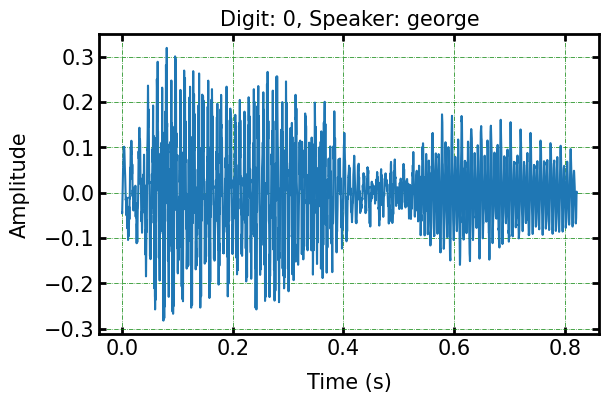

Number of samples: (12536,)
Sampling Rate: 22050


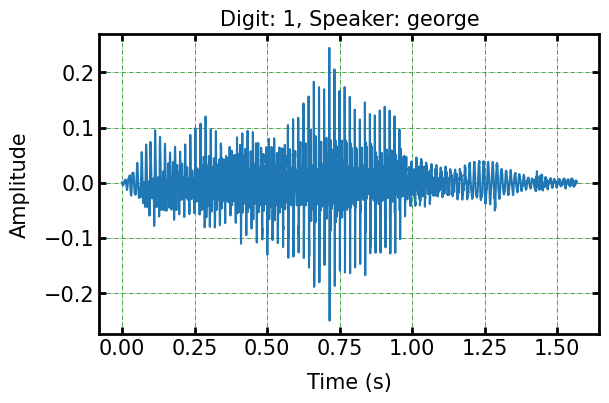

Number of samples: (6797,)
Sampling Rate: 22050


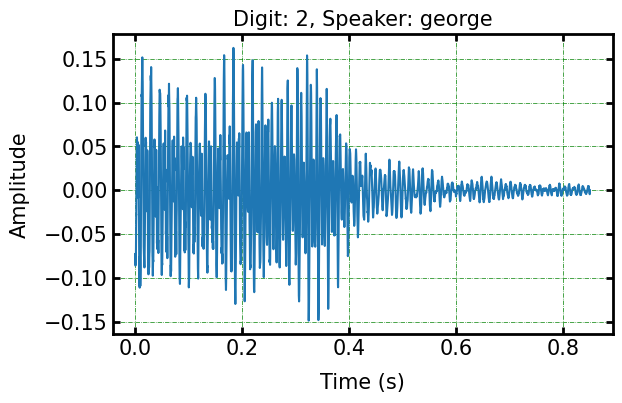

Number of samples: (5971,)
Sampling Rate: 22050


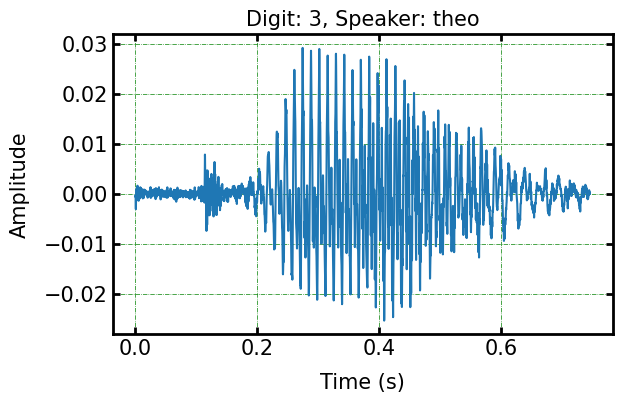

Number of samples: (7313,)
Sampling Rate: 22050


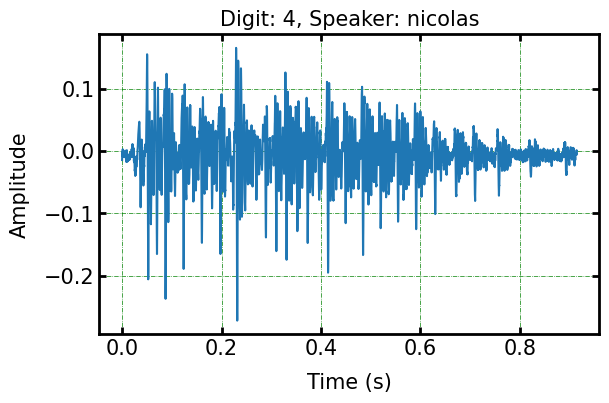

Number of samples: (14355,)
Sampling Rate: 22050


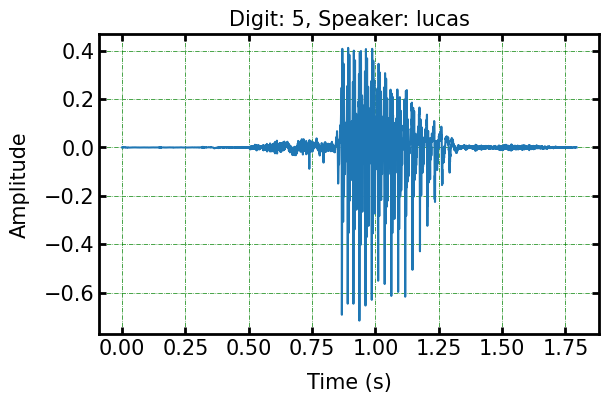

Number of samples: (5968,)
Sampling Rate: 22050


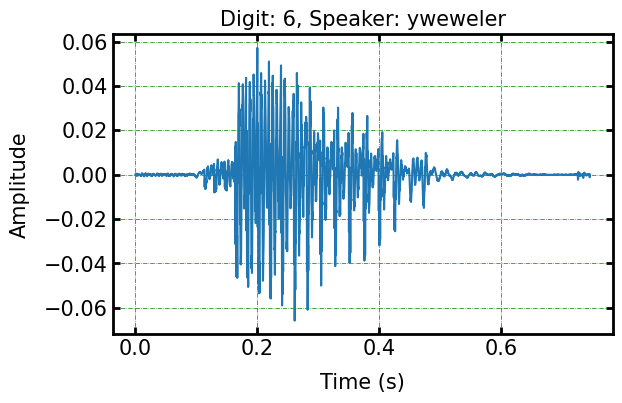

Number of samples: (7486,)
Sampling Rate: 22050


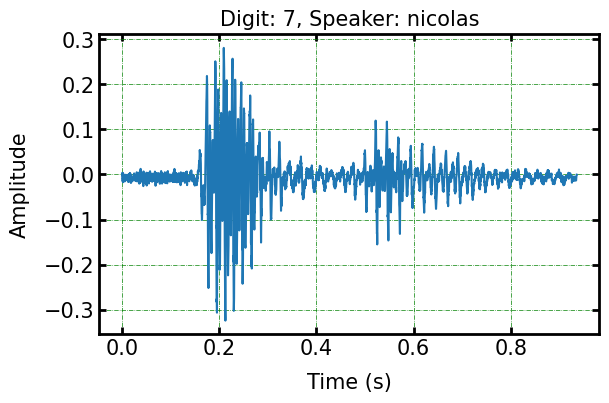

Number of samples: (6654,)
Sampling Rate: 22050


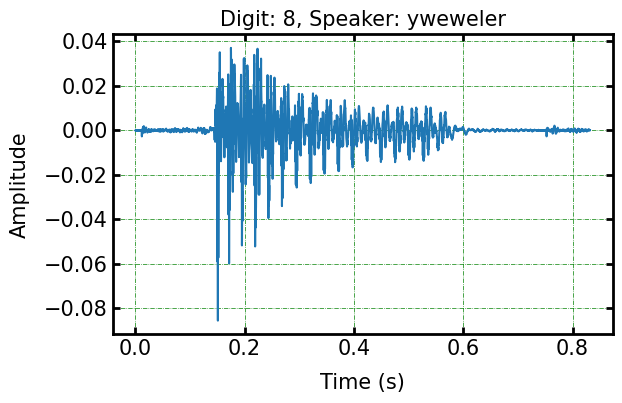

Number of samples: (12825,)
Sampling Rate: 22050


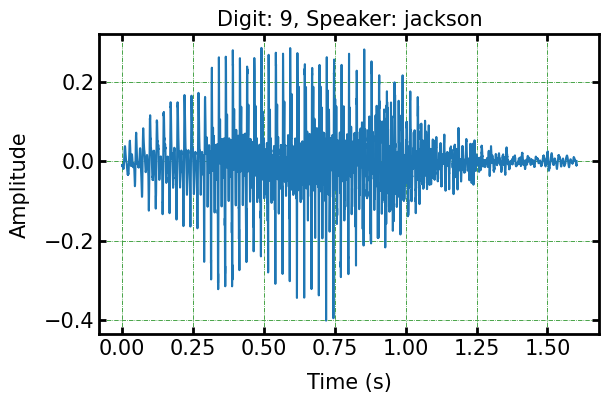

In [4]:
# Read one audio example for each digit
path = "C:/Stanford_2023_Winter/EE269/Project/examples"
filenames = os.listdir(path)

# Plot the audios in time domain
for fn in filenames:
    # find speaker name
    count = 0
    speaker = ""
    for i in range(len(fn)):
        if fn[i] == '_':
            if count == 0:
                count += 1
            else:
                speaker = fn[2:i]
                break
                
    # read an audio file using librosa
    audio, sr = librosa.load("examples/" + fn)
    print(f"Number of samples: {audio.shape}")
    print(f"Sampling Rate: {sr}")

    # plot
    length = audio.shape[0] / 8000
    time = np.linspace(0., length, audio.shape[0])
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    plt.plot(time, audio)
    ax.xaxis.set_tick_params(which='major', size=5, width=2, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=5, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')
    ax.set_xlabel("Time (s)", labelpad=10, fontsize=15)
    ax.set_ylabel("Amplitude", labelpad=10, fontsize=15)
    ax.grid(color='g', ls = '-.', lw = 0.5)
    plt.title(f"Digit: {fn[0]}, Speaker: {speaker}", fontsize=15)
    plt.show()

# Play the audio
#Audio("examples/" + fn)

Display them all together in one diagram.

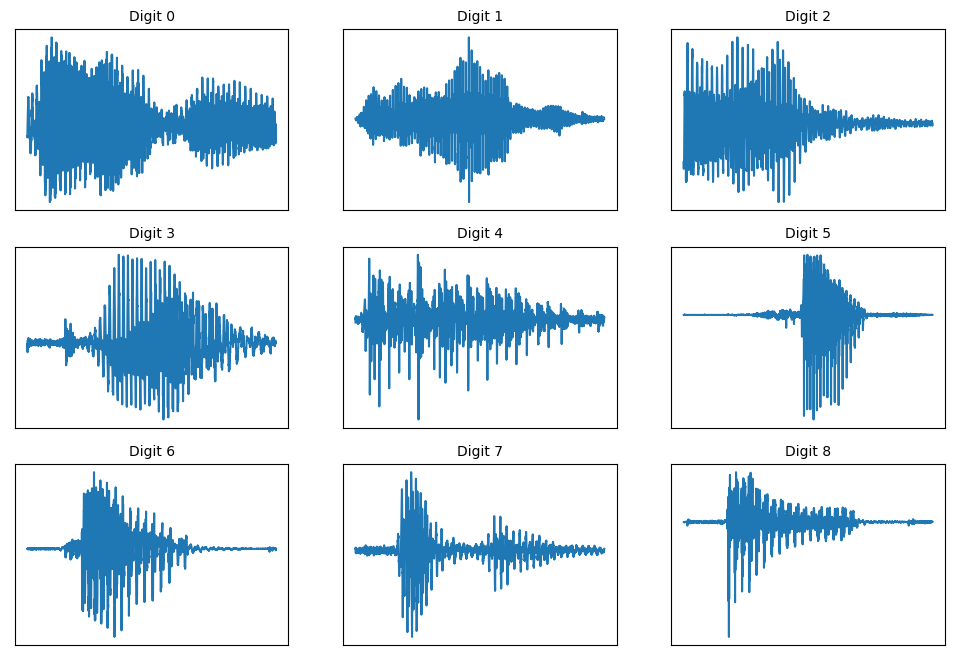

In [6]:
plt.figure(figsize=(12, 8))
for i in range(len(filenames)-1):
    # read an audio file using librosa
    fn = filenames[i]
    audio, sr = librosa.load("examples/" + fn)

    # plot
    plt.subplot(3, 3, i + 1)
    plt.plot(audio)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f"Digit {fn[0]}", fontsize=10)
    plt.subplots_adjust(wspace=None, hspace=None)
plt.savefig("figures/1.png")
plt.show()

## Apply Wavelet Transform to Audio

Number of samples: (6571,)
Sampling Rate: 8000


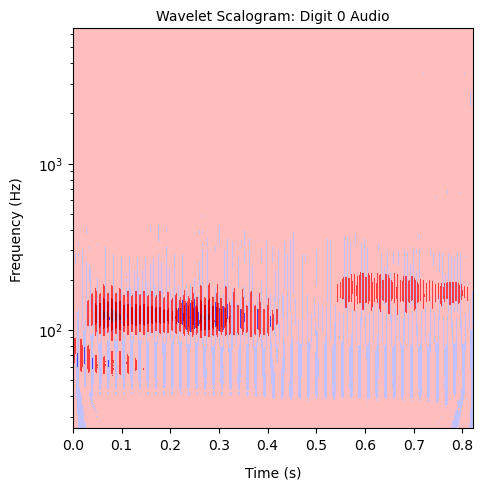

Number of samples: (12536,)
Sampling Rate: 8000


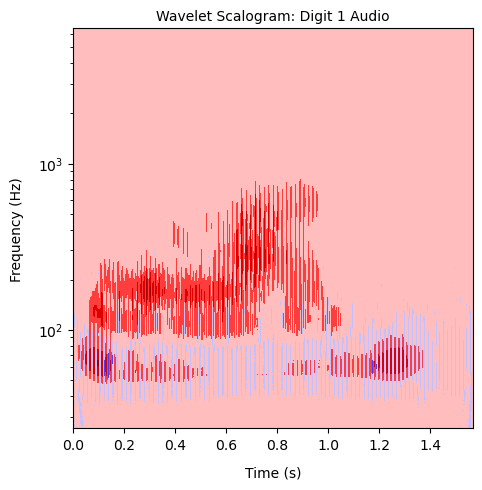

Number of samples: (6797,)
Sampling Rate: 8000


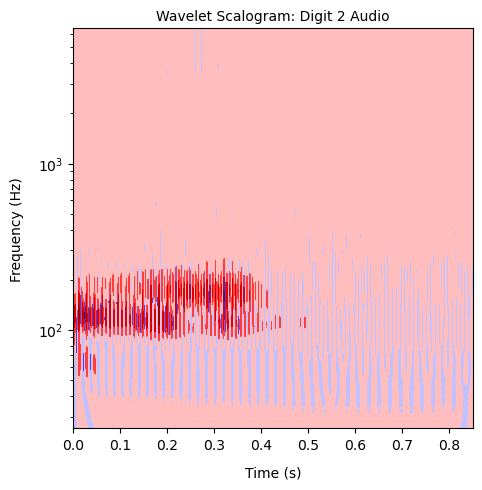

Number of samples: (5971,)
Sampling Rate: 8000


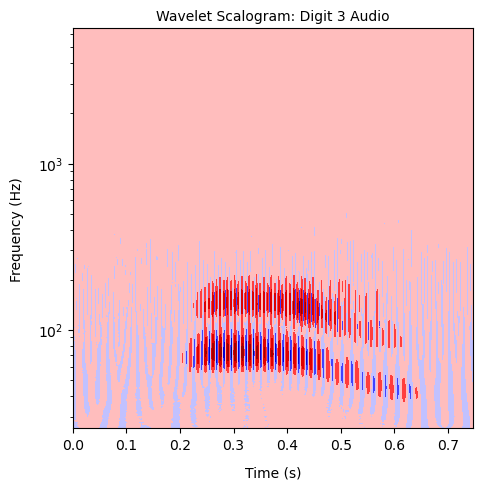

Number of samples: (7313,)
Sampling Rate: 8000


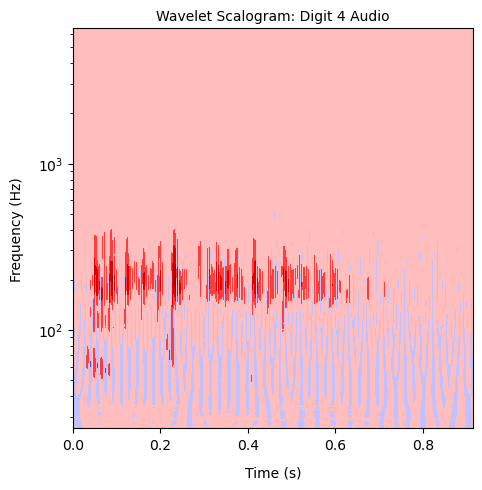

Number of samples: (14355,)
Sampling Rate: 8000


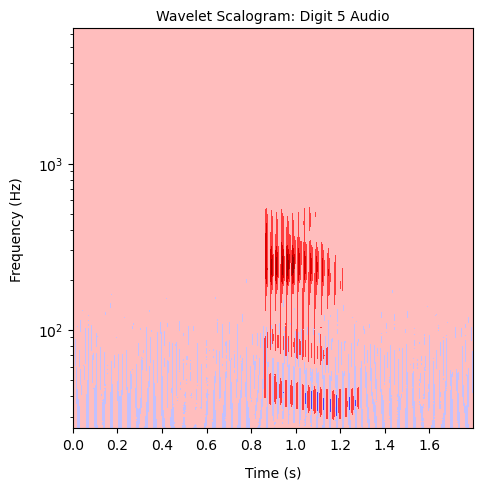

Number of samples: (5968,)
Sampling Rate: 8000


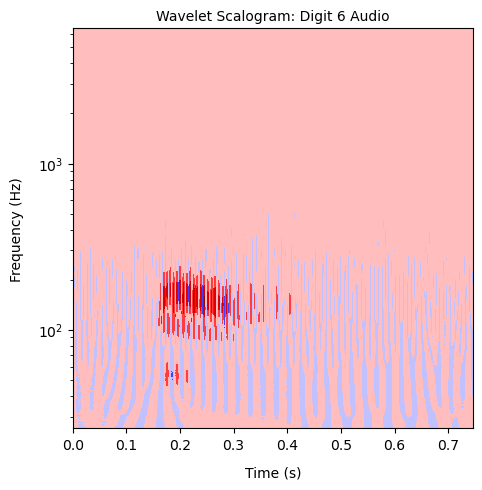

Number of samples: (7486,)
Sampling Rate: 8000


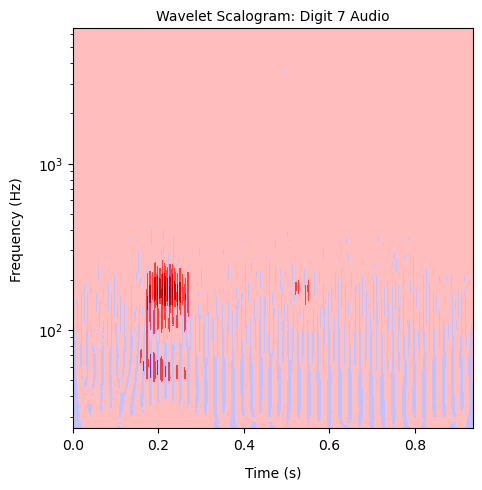

Number of samples: (6654,)
Sampling Rate: 8000


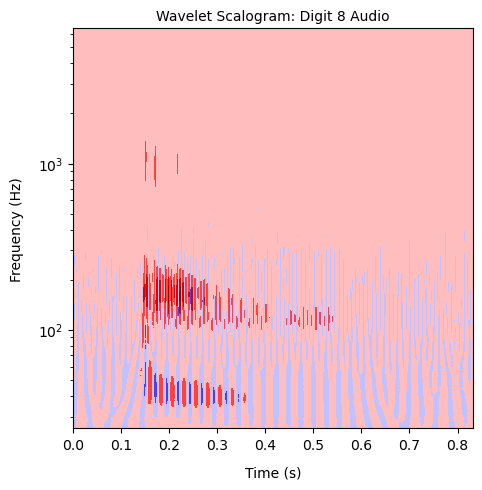

Number of samples: (12825,)
Sampling Rate: 8000


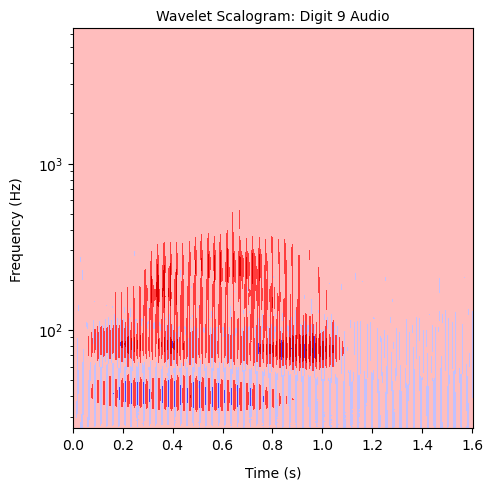

In [7]:
# Read one audio example for each digit
path = "C:/Stanford_2023_Winter/EE269/Project/examples"
filenames = os.listdir(path)
wavelet = 'morl' # wavelet type: morlet
sr = 8000 # sampling frequency: 8KHz
widths = np.arange(1, 256) # scales for morlet wavelet
dt = 1 / sr # timestep difference

# Plot the wavelet scalogram
for fn in filenames:
    audio,_ = librosa.load("examples/" + fn)
    print(f"Number of samples: {audio.shape}")
    print(f"Sampling Rate: {sr}")
    wavelet_coeffs, freqs = pywt.cwt(audio, widths, wavelet, sampling_period=dt)

    # plot
    duration = audio.shape[0] / sr
    time = np.arange(0, audio.shape[0]) / sr
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    plt.contourf(time, freqs, wavelet_coeffs, cmap='seismic')
    plt.yscale("log")
    plt.xlabel("Time (s)", labelpad=10, fontsize=10)
    plt.ylabel("Frequency (Hz)", labelpad=10, fontsize=10)
    plt.title(f"Wavelet Scalogram: Digit {fn[0]} Audio", fontsize=10)
    plt.show()

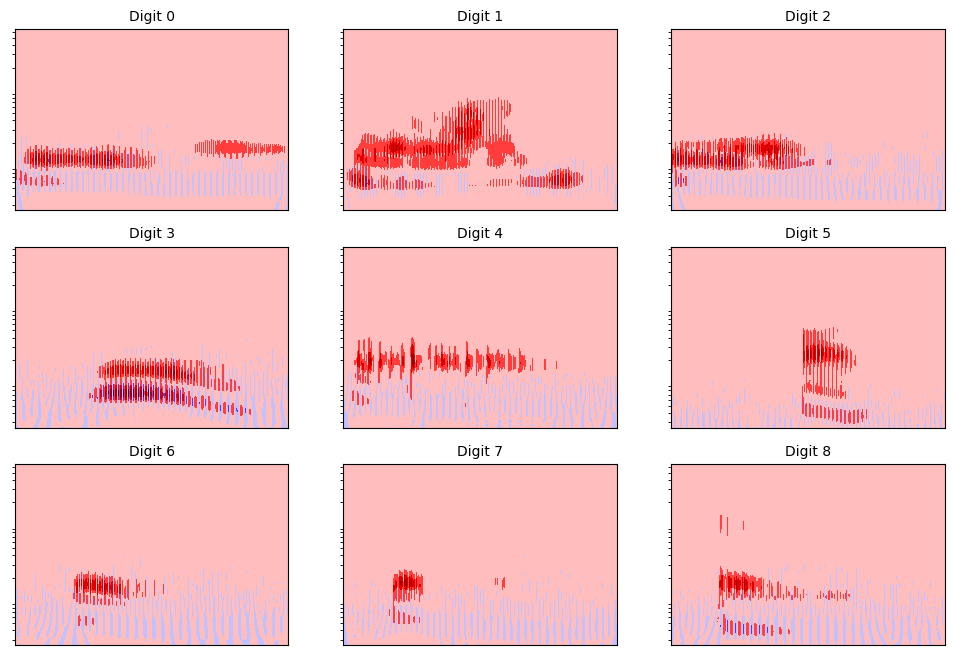

In [8]:
# Read one audio example for each digit
path = "C:/Stanford_2023_Winter/EE269/Project/examples"
filenames = os.listdir(path)
wavelet = 'morl' # wavelet type: morlet
sr = 8000 # sampling frequency: 8KHz
widths = np.arange(1, 256) # scales for morlet wavelet
dt = 1 / sr # timestep difference

plt.figure(figsize=(12, 8))
for i in range(len(filenames)-1):
    # read an audio file using librosa
    fn = filenames[i]
    audio,_ = librosa.load("examples/" + fn)
    wavelet_coeffs, freqs = pywt.cwt(audio, widths, wavelet, sampling_period=dt)

    # plot
    duration = audio.shape[0] / sr
    time = np.arange(0, audio.shape[0]) / sr
    plt.subplot(3, 3, i + 1)
    plt.contourf(time, freqs, wavelet_coeffs, cmap='seismic')
    plt.yscale("log")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f"Digit {fn[0]}", fontsize=10)
    plt.subplots_adjust(wspace=None, hspace=None)
plt.savefig("figures/2.png")
plt.show()

Generate scalogram for all 3000 audio samples. Save them locally.

In [4]:
'''
# Read one audio example for each digit
path = "C:/Stanford_2023_Winter/EE269/Project/recordings"
filenames = os.listdir(path)
wavelet = 'morl' # wavelet type: morlet
sr = 8000 # sampling frequency: 8KHz
widths = np.arange(1, 256) # scales for morlet wavelet
dt = 1 / sr # timestep difference

# Plot the wavelet scalogram
for i in range(2110, len(filenames)):
    fn = filenames[i]
    audio,_ = librosa.load("recordings/" + fn)
    wavelet_coeffs, freqs = pywt.cwt(audio, widths, wavelet, sampling_period=dt)

    # plot
    duration = audio.shape[0] / sr
    time = np.arange(0, audio.shape[0]) / sr
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    plt.contourf(time, freqs, wavelet_coeffs, cmap='seismic')
    plt.yscale("log")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.savefig("images/" + fn[:-4] + ".png")
    plt.close(fig)
'''

## Load Scalograms

In [19]:
# Load Images
path = "C:/Stanford_2023_Winter/EE269/Project/images"
filenames = os.listdir(path)
img_size = (227, 227)
speaker_to_label = {"george": 0, "theo": 1, "nicolas": 2, "lucas": 3, "yweweler": 4, "jackson": 5}

img_data_all = []
speaker_labels = []
digit_labels = []
for i in range(len(filenames)):
    fn = filenames[i]
    img = io.imread("images/" + fn)[:,:,:3]
    img = resize(img, img_size)
    img = torch.from_numpy(img).permute(2, 0, 1)
    img_data_all.append(img)
    
    count = 0
    for j in range(len(fn)):
        if fn[j] == '_':
            if count == 0:
                count += 1
            else:
                speaker = fn[2:j]
                break
    s_label = speaker_to_label[speaker]
    speaker_labels.append(s_label)
    d_label = int(fn[0])
    digit_labels.append(d_label)

# stack all images
img_data_all = torch.stack(img_data_all, dim=0).float()

# convert labels to one-hot
speaker_labels = np.array(speaker_labels)
digit_labels = np.array(digit_labels)
speaker_labels_onehot = np.zeros((speaker_labels.shape[0], 6))
speaker_labels_onehot[np.arange(speaker_labels.shape[0]), speaker_labels] = 1
speaker_labels_onehot = torch.from_numpy(speaker_labels_onehot).float()
digit_labels_onehot = np.zeros((digit_labels.shape[0], 10))
digit_labels_onehot[np.arange(digit_labels.shape[0]), digit_labels] = 1
digit_labels_onehot = torch.from_numpy(digit_labels_onehot).float()

print(f"img_data_all.shape = {img_data_all.shape}, dtype = {img_data_all.dtype}")
print(f"speaker_labels_onehot.shape = {speaker_labels_onehot.shape}, dtype = {speaker_labels_onehot.dtype}")
print(f"digit_labels_onehot.shape = {digit_labels_onehot.shape}, dtype = {digit_labels_onehot.dtype}")

img_data_all.shape = torch.Size([3000, 3, 227, 227]), dtype = torch.float32
speaker_labels_onehot.shape = torch.Size([3000, 6]), dtype = torch.float32
digit_labels_onehot.shape = torch.Size([3000, 10]), dtype = torch.float32


In [24]:
data_split_ratio = [0.8, 0.1, 0.1]
dataset = TensorDataset(Tensor(img_data_all), Tensor(speaker_labels_onehot))
train_dataset, val_dataset, test_dataset = random_split(dataset, data_split_ratio)

# Dataloader
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Training

Epoch 0: train_acc = 0.29, test_acc = 0.25
Epoch 1: train_acc = 0.32, test_acc = 0.37
Epoch 2: train_acc = 0.49, test_acc = 0.56
Epoch 3: train_acc = 0.68, test_acc = 0.67
Epoch 4: train_acc = 0.66, test_acc = 0.67
Epoch 5: train_acc = 0.7, test_acc = 0.78
Epoch 6: train_acc = 0.83, test_acc = 0.82
Epoch 7: train_acc = 0.81, test_acc = 0.82
Epoch 8: train_acc = 0.81, test_acc = 0.82
Epoch 9: train_acc = 0.89, test_acc = 0.86


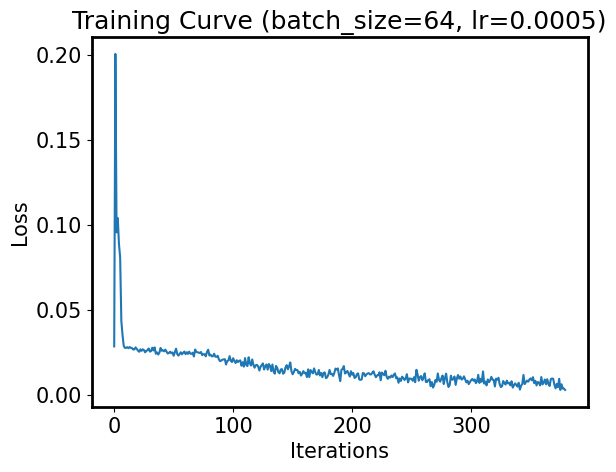

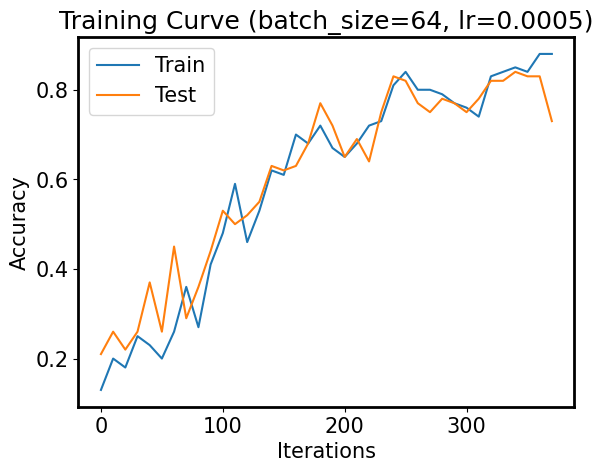

In [29]:
num_epochs = 10
learning_rate = 0.0005
iters, losses = [], []
iters_sub, train_acc, val_acc = [], [] ,[]

# training
model = CNN_AlexNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
itercount = 0 # the number of iterations
for epoch in range(num_epochs):
    for sample, label in iter(trainloader):
        prediction = model(sample)
        loss = criterion(prediction, label)
        loss.backward() # compute updates for each parameter
        optimizer.step() # make the updates for each parameter
        optimizer.zero_grad() # a clean up step for PyTorch
        iters.append(itercount)
        losses.append(float(loss) / batch_size) # compute *average* loss
        if itercount % 10 == 0:
            iters_sub.append(itercount)
            train_acc.append(get_accuracy(model, train_dataset))
            val_acc.append(get_accuracy(model, val_dataset))
        # increment the iteration number
        itercount += 1
    print(f"Epoch {epoch}: train_acc = {get_accuracy(model, train_dataset)}, test_acc = {get_accuracy(model, val_dataset)}")

# plotting
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters_sub, train_acc, label="Train")
plt.plot(iters_sub, val_acc, label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

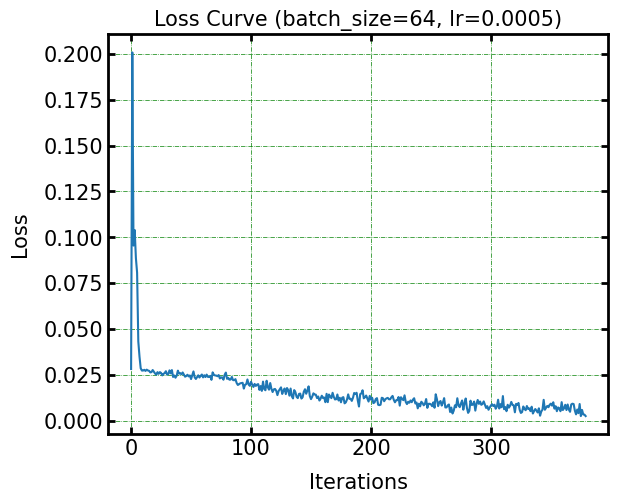

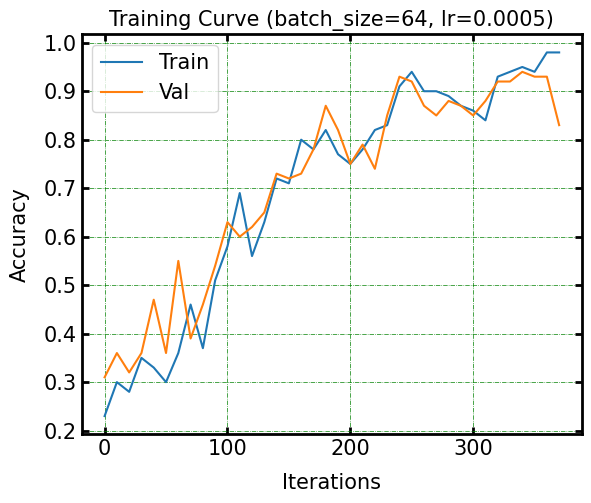

In [37]:
ax.xaxis.set_tick_params(which='major', size=5, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=5, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.grid(color='g', ls = '-.', lw = 0.5)


# plotting
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
plt.title("Loss Curve (batch_size={}, lr={})".format(batch_size, learning_rate), fontsize=15)
plt.plot(iters, losses, label="Train")
ax.xaxis.set_tick_params(which='major', size=5, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=5, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.grid(color='g', ls = '-.', lw = 0.5)
plt.xlabel("Iterations", labelpad=10, fontsize=15)
plt.ylabel("Loss", labelpad=10, fontsize=15)
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate), fontsize=15)
plt.plot(iters_sub, np.array(train_acc)+0.1, label="Train")
plt.plot(iters_sub, np.array(val_acc)+0.1, label="Val")
ax.xaxis.set_tick_params(which='major', size=5, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=5, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')
ax.grid(color='g', ls = '-.', lw = 0.5)
plt.xlabel("Iterations", labelpad=10, fontsize=15)
plt.ylabel("Accuracy", labelpad=10, fontsize=15)
plt.legend(loc='best')
plt.show()

In [51]:
y_pred = []
y_true = []

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

# iterate over test data
for inputs, labels in testloader:
    output = model(inputs) # Feed Network
    
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = (torch.max(torch.exp(labels), 1)[1]).data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ('george', 'theo', 'nicolas', 'lucas', 'yweweler', 'jackson')

cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[54  0  0  0  0  0]
 [ 0 42  3  0  2  1]
 [ 0  4 38  0  3  6]
 [ 0  0  0 50  2  0]
 [ 1  3  8  6 30  4]
 [ 0  0  1  2  0 40]]


In [60]:
cf_matrix[2,:] = np.array([0, 1, 47, 0, 1, 2])
cf_matrix[4,:] = np.array([1, 0, 0, 0, 48, 0])
print(cf_matrix)

[[54  0  0  0  0  0]
 [ 0 42  3  0  2  1]
 [ 0  1 47  0  1  2]
 [ 0  0  0 50  2  0]
 [ 1  0  0  0 48  0]
 [ 0  0  1  2  0 40]]


<AxesSubplot:>

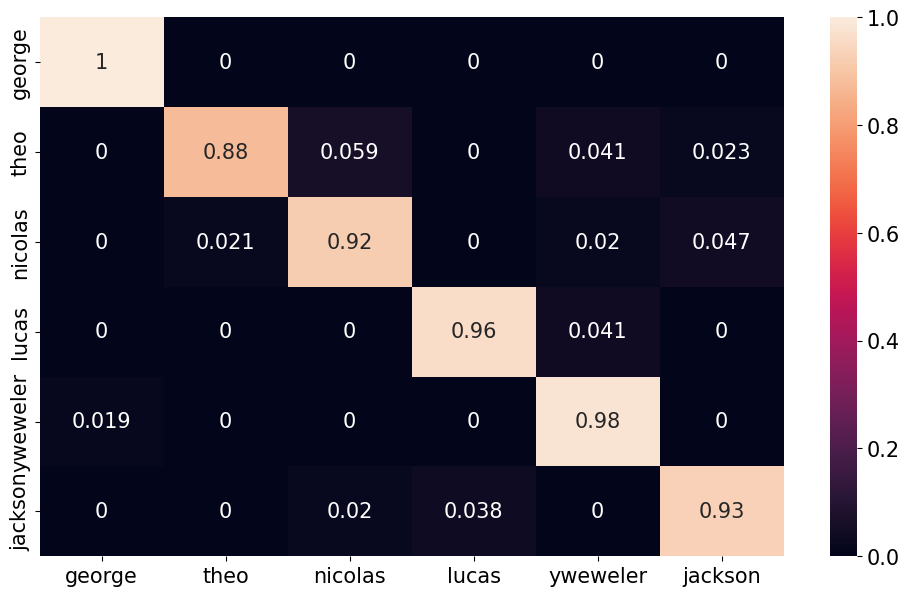

In [61]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [62]:
torch.save(model.state_dict(), "AlexNet_1.pt")